# **ETL Pipeline for Customer Purchase Behavior Analysis**  
This notebook performs **Extract, Transform, and Load (ETL)** operations on the *Customer Purchase Behavior* dataset. The pipeline involves:  
1. **Extracting Data** from IBM Cloud Object Storage (COS)  
2. **Data Cleaning & Transformation**  
3. **Exploratory Data Analysis (EDA)**  
4. **Saving Processed Data** back to IBM COS  

## **1️ Extract: Load Data from IBM Cloud Object Storage (COS)**  

In [ ]:
import ibm_boto3
from ibm_botocore.client import Config

# IBM COS Credentials (Replace with actual values)
cos_credentials = {
    "access_key_id": "access_key_id",
    "secret_access_key": "secret_access_key",
    "endpoint": "https://s3.eu-de.cloud-object-storage.appdomain.cloud",
    "resource_instance_id": "resource_id"
}

# Create COS Client
cos = ibm_boto3.client(
    service_name="s3",
    aws_access_key_id=cos_credentials["access_key_id"],
    aws_secret_access_key=cos_credentials["secret_access_key"],
    endpoint_url=cos_credentials["endpoint"]
)

print("✅ Successfully connected to IBM Cloud Object Storage in Frankfurt!")


✅ Successfully connected to IBM Cloud Object Storage in Frankfurt!


### **🔹 Connect to IBM COS**
- Establishes a connection using `ibm_boto3` to interact with COS.
- Ensure credentials (access key, secret key, endpoint) are correctly set.  


### **Load Dataset from COS**
- Retrieves the CSV file from the **raw-data-bucket** and reads it into a Pandas DataFrame.


In [ ]:
import pandas as pd
import io

# Define the dataset file
bucket_name = "raw-data-bucket"
file_name = "customer_purchase_behavior.csv"

# Download file from COS
response = cos.get_object(Bucket=bucket_name, Key=file_name)
df = pd.read_csv(io.BytesIO(response['Body'].read()))

# Show the first 5 rows
df.head()

# import pandas as pd

# file_path = "Customer Purchase Behavior/customer_purchase_behavior.csv"

# df = pd.read_csv(file_path)

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Credit Card,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Bank Transfer,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Cash,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,PayPal,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Cash,Free Shipping,Yes,Yes,31,PayPal,Annually


## **2️ Data Exploration & Preprocessing**  

### **Check Dataset Info**
- Displays column names, data types, and unique value counts.

In [ ]:
# Display column names and data types
print(df.dtypes)

# Count unique values in each column
unique_counts = df.nunique()
print(unique_counts)


Customer ID                   int64
Age                           int64
Gender                       object
Item Purchased               object
Category                     object
Purchase Amount (USD)         int64
Location                     object
Size                         object
Color                        object
Season                       object
Review Rating               float64
Subscription Status          object
Payment Method               object
Shipping Type                object
Discount Applied             object
Promo Code Used              object
Previous Purchases            int64
Preferred Payment Method     object
Frequency of Purchases       object
dtype: object
Customer ID                 3900
Age                           53
Gender                         2
Item Purchased                25
Category                       4
Purchase Amount (USD)         81
Location                      50
Size                           4
Color                         25
Seaso

### **List Available Buckets & Files**
- Verifies bucket availability and lists files in **raw-data-bucket**.

In [ ]:
# List all available buckets in Frankfurt
buckets = cos.list_buckets()

if "Buckets" in buckets:
    print("✅ Buckets Found:")
    for bucket in buckets["Buckets"]:
        print(" -", bucket["Name"])
else:
    print("❌ No buckets found. Check credentials or bucket region.")


✅ Buckets Found:
 - 05124e53-c488-477d-92ff-24f71f18fd2f
 - bigdataanalytics-donotdelete-pr-vk9ojs5kpio8uc
 - customerpurchaseanalytics-donotdelete-pr-nmlj6djptuczxt
 - processed-data-bucket
 - raw-data-bucket


## **3️ Data Cleaning & Transformation**  

### **Handling Missing & Duplicate Data**
- **Remove duplicates**
- **Fill missing numerical values** with the median.
- **Fill missing categorical values** with `"Unknown"`.
- Convert certain fields into **numeric/binary formats**.

### **Convert Data Types**
- Converts **numeric columns** to the appropriate format.
- **Binary encoding** for `Subscription Status`, `Discount Applied`, and `Promo Code Used`.

### **High-Value Customer Classification**
- Customers spending above the **75th percentile** are marked as `"High Value"`.

In [ ]:
# Drop duplicate records
df = df.drop_duplicates()

# Fill missing numerical values with median
df = df.fillna({
    "Age": df["Age"].median(),
    "Purchase Amount (USD)": df["Purchase Amount (USD)"].median(),
    "Review Rating": df["Review Rating"].median(),
})

# Fill missing categorical columns with "Unknown"
categorical_cols = ["Gender", "Item Purchased", "Category", "Location", "Size", "Color", "Season",
                    "Subscription Status", "Payment Method", "Shipping Type", "Promo Code Used",
                    "Preferred Payment Method", "Discount Applied"]

df[categorical_cols] = df[categorical_cols].fillna("Unknown")

# Convert 'Purchase Amount (USD)' and 'Review Rating' to numeric
df["Purchase Amount (USD)"] = pd.to_numeric(df["Purchase Amount (USD)"], errors="coerce")
df["Review Rating"] = pd.to_numeric(df["Review Rating"], errors="coerce")

# Convert 'Subscription Status', 'Discount Applied', and 'Promo Code Used' to binary (0: No, 1: Yes)
df["Subscription Status"] = df["Subscription Status"].str.lower().eq("yes").astype(int)
df["Discount Applied"] = df["Discount Applied"].str.lower().eq("yes").astype(int)
df["Promo Code Used"] = df["Promo Code Used"].str.lower().eq("yes").astype(int)

# Use the 75th percentile as the threshold for High-Value Customer
threshold = df["Purchase Amount (USD)"].quantile(0.75)

# Assign High-Value Customer based on the threshold
df["High Value Customer"] = (df["Purchase Amount (USD)"] > threshold).map({True: "Yes", False: "No"})

print(f"Threshold for High-Value Customer: ${threshold:.2f}")
df["High Value Customer"].value_counts()

print("✅ Data Cleaning & Transformation Complete!")
df.head()


Threshold for High-Value Customer: $81.00
✅ Data Cleaning & Transformation Complete!


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases,High Value Customer
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,1,Credit Card,Express,1,1,14,Venmo,Fortnightly,No
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,1,Bank Transfer,Express,1,1,2,Cash,Fortnightly,No
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,1,Cash,Free Shipping,1,1,23,Credit Card,Weekly,No
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,1,PayPal,Next Day Air,1,1,49,PayPal,Weekly,Yes
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,1,Cash,Free Shipping,1,1,31,PayPal,Annually,No


In [ ]:
# List objects in raw-data-bucket
objects = cos.list_objects_v2(Bucket="raw-data-bucket")

if "Contents" in objects:
    print("✅ Files in raw-data-bucket:")
    for obj in objects["Contents"]:
        print(obj["Key"])  # Prints filenames
else:
    print("❌ No files found in raw-data-bucket. Ensure dataset is uploaded.")


✅ Files in raw-data-bucket:
customer_purchase_behavior.csv


## **4️ Exploratory Data Analysis (EDA)**  

### **Data Summary & Statistics**
- Checks **missing values, duplicates, and summary statistics**.

In [ ]:
# Check Data Types
print(df.info())

# Check for Missing Values
print("\nMissing Values:\n", df.isnull().sum())

# Check for Duplicates
print("\nDuplicate Rows:", df.duplicated().sum())

# Summary Statistics
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               3900 non-null   int64  
 1   Age                       3900 non-null   int64  
 2   Gender                    3900 non-null   object 
 3   Item Purchased            3900 non-null   object 
 4   Category                  3900 non-null   object 
 5   Purchase Amount (USD)     3900 non-null   int64  
 6   Location                  3900 non-null   object 
 7   Size                      3900 non-null   object 
 8   Color                     3900 non-null   object 
 9   Season                    3900 non-null   object 
 10  Review Rating             3900 non-null   float64
 11  Subscription Status       3900 non-null   int64  
 12  Payment Method            3900 non-null   object 
 13  Shipping Type             3900 non-null   object 
 14  Discount

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Payment Method,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Preferred Payment Method,Frequency of Purchases,High Value Customer
count,3900.000000,3900.000000,3900,3900,3900,3900.000000,3900,3900,3900,3900,3900.000000,3900.000000,3900,3900,3900.000000,3900.000000,3900.000000,3900,3900,3900
unique,NaN,NaN,2,25,4,NaN,50,4,25,4,NaN,NaN,6,6,NaN,NaN,NaN,6,7,2
top,NaN,NaN,Male,Blouse,Clothing,NaN,Montana,M,Olive,Spring,NaN,NaN,Credit Card,Free Shipping,NaN,NaN,NaN,PayPal,Every 3 Months,No
freq,NaN,NaN,2652,171,1737,NaN,96,1755,177,999,NaN,NaN,696,675,NaN,NaN,NaN,677,584,2974
mean,1950.500000,44.068462,NaN,NaN,NaN,59.764359,NaN,NaN,NaN,NaN,3.749949,0.270000,NaN,NaN,0.430000,0.430000,25.351538,NaN,NaN,NaN
std,1125.977353,15.207589,NaN,NaN,NaN,23.685392,NaN,NaN,NaN,NaN,0.716223,0.444016,NaN,NaN,0.495139,0.495139,14.447125,NaN,NaN,NaN
min,1.000000,18.000000,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,NaN,2.500000,0.000000,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN,NaN
25%,975.750000,31.000000,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,NaN,3.100000,0.000000,NaN,NaN,0.000000,0.000000,13.000000,NaN,NaN,NaN
50%,1950.500000,44.000000,NaN,NaN,NaN,60.000000,NaN,NaN,NaN,NaN,3.700000,0.000000,NaN,NaN,0.000000,0.000000,25.000000,NaN,NaN,NaN
75%,2925.250000,57.000000,NaN,NaN,NaN,81.000000,NaN,NaN,NaN,NaN,4.400000,1.000000,NaN,NaN,1.000000,1.000000,38.000000,NaN,NaN,NaN


### **Visualizing High-Value Customers**
- **Seaborn count plot** for `High Value Customer` distribution.

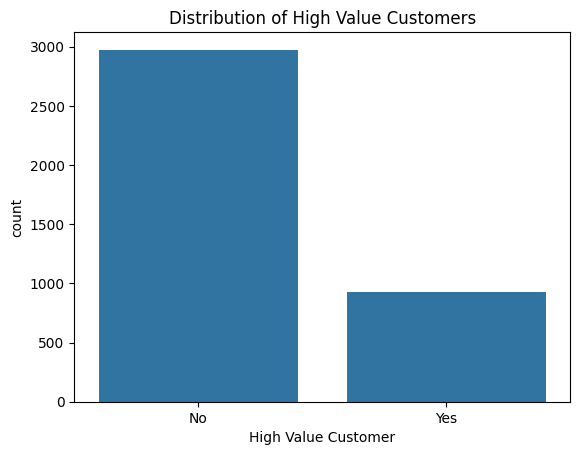

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df["High Value Customer"])
plt.title("Distribution of High Value Customers")
plt.show()

## **5️ Load: Save Processed Data**  

### **Upload Processed Data to IBM COS**
- Saves the cleaned dataset in **processed-data-bucket**.

In [ ]:
import io

# Save DataFrame to CSV in memory
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False)

# Upload processed data to IBM COS
cos.put_object(
    Bucket="processed-data-bucket",
    Key="processed_customer_purchase_behavior.csv",
    Body=csv_buffer.getvalue()
)

print("✅ Processed data uploaded to 'processed-data-bucket' successfully!")


✅ Processed data uploaded to 'processed-data-bucket' successfully!


### **Save Processed Data Locally**
- Saves the cleaned dataset in a local directory for further use.

In [ ]:
import pandas as pd
import os

# Ensure the directory exists
local_dir = "processed-data-bucket"
os.makedirs(local_dir, exist_ok=True)

# Define file path
file_path = os.path.join(local_dir, "processed_customer_purchase_behavior.csv")

# Save DataFrame as CSV locally
df.to_csv(file_path, index=False)

print(f"✅ Processed data saved locally at '{file_path}'")


✅ Processed data saved locally at 'processed-data-bucket/processed_customer_purchase_behavior.csv'


## **ETL Pipeline**
| Step | Description |
|------|-------------|
| **Extract** | Fetches raw data from IBM COS |
| **Transform** | Cleans missing values, encodes categorical data, classifies high-value customers |
| **Load** | Saves processed data back to IBM COS & locally |
